In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import joblib


In [2]:
# Cargar los datos de generación y meteorológicos para la planta 2
plant_2_generation = pd.read_csv('Plant_2_Generation_Data.csv')
plant_2_weather = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Copiar los datos de generación para mantener df_GD2 limpio
df_GD2 = plant_2_generation.copy()

# Aplicar el mapeo a los nombres de los paneles solares
unique_source_keys_list_2 = df_GD2['SOURCE_KEY'].unique()
source_key_mapping_2 = {key: f"Solar_Panel_{i+1}" for i, key in enumerate(unique_source_keys_list_2)}
df_GD2['SOURCE_KEY'] = df_GD2['SOURCE_KEY'].map(source_key_mapping_2)

# Convertir la columna 'DATE_TIME' a formato de fecha y hora
# Ajustar el formato de fecha según sea necesario para que coincida con el archivo de la planta 2
df_GD2['DATE_TIME'] = pd.to_datetime(df_GD2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
plant_2_weather['DATE_TIME'] = pd.to_datetime(plant_2_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Unir los datos meteorológicos al dataframe de generación en función de la fecha y hora
df_GD2_with_weather = pd.merge(df_GD2, plant_2_weather, on='DATE_TIME', how='left')

# Eliminar las columnas PLANT_ID_y y SOURCE_KEY_y y renombrar las columnas PLANT_ID_x y SOURCE_KEY_x
df_GD2_with_weather_clean = df_GD2_with_weather.drop(columns=['PLANT_ID_y', 'SOURCE_KEY_y', 'PLANT_ID_x'])

# Renombrar las columnas para eliminar el sufijo '_x'
df_GD2_with_weather_clean = df_GD2_with_weather_clean.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

# Mostrar cuántos valores nulos hay por columna
nulos2 = df_GD2_with_weather_clean.isnull().sum()
print("Valores nulos en cada columna (planta 2):\n", nulos2)

# Rellenar los valores nulos en solo las columnas numéricas con la media
numerical_cols_2 = df_GD2_with_weather_clean.select_dtypes(include=['float64', 'int64']).columns
df_GD2_with_weather_clean[numerical_cols_2] = df_GD2_with_weather_clean[numerical_cols_2].fillna(df_GD2_with_weather_clean[numerical_cols_2].mean())

# Guardar el dataframe limpio de la planta 2
df_GD2_limpio = df_GD2_with_weather_clean

Valores nulos en cada columna (planta 2):
 DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [ ]:
features = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION']
# Definir X (variables predictoras) y Y (variable objetivo)
X_ker = df_GD2_limpio[features].values
Y_ker = df_GD2_limpio['DC_POWER'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_ker):
    X_train_ker, X_test_ker = X_ker[train_index], X_ker[test_index]
    Y_train_ker, Y_test_ker = Y_ker[train_index], Y_ker[test_index]
    
    scaler_ker = MinMaxScaler()
    X_train_ker = scaler_ker.fit_transform(X_train_ker)
    X_test_ker = scaler_ker.transform(X_test_ker)
    joblib.dump(scaler_ker, 'scaler_ker2.pkl')
    
    
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_ker.shape[1],), kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_ker, Y_train_ker, epochs=100, batch_size=32, verbose=0,validation_data=(X_test_ker, Y_test_ker), callbacks=[early_stop])
    
    mse, mae = model.evaluate(X_test_ker, Y_test_ker, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    Y_test_pred = model.predict(X_test_ker, verbose=0)
    r2 = r2_score(Y_test_ker, Y_test_pred)
    r2_scores.append(r2)
  

print("MSE en cada fold:", mse_scores)
print("MSE promedio en validación cruzada:", np.mean(mse_scores))
print("MAE en cada fold:", mae_scores)
print("MAE promedio en validación cruzada:", np.mean(mae_scores))
print("R² en cada fold:", r2_scores)
print("R² promedio en validación cruzada:", np.mean(r2_scores))


MSE en cada fold: [62.32850646972656, 73.07862091064453, 103.7606201171875, 90.55905151367188, 56.519134521484375]

MSE promedio en validación cruzada: 77.24918670654297

MAE en cada fold: [2.724015951156616, 3.6545634269714355, 4.477487564086914, 4.092912197113037, 2.367548942565918]

MAE promedio en validación cruzada: 3.463305616378784

R² en cada fold: [0.9998338355572783, 0.9997193536561324, 0.9994696329800683, 0.9995921764835287, 0.999880124775671]

R² promedio en validación cruzada: 0.9996990246905357

In [ ]:
model.save('Modelo_SP2.h5')

In [3]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler


# Transformar DATE_TIME en características útiles
df_GD2_limpio['HOUR'] = pd.to_datetime(df_GD2_limpio['DATE_TIME']).dt.hour

# Codificación trigonométrica para la hora del día
df_GD2_limpio['HOUR_SIN'] = np.sin(2 * np.pi * df_GD2_limpio['HOUR'] / 24)
df_GD2_limpio['HOUR_COS'] = np.cos(2 * np.pi * df_GD2_limpio['HOUR'] / 24)

# Definir las características (X) y la variable objetivo (Y)
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR_SIN', 'HOUR_COS']
X = df_GD2_limpio[features].values
Y = df_GD2_limpio['DC_POWER'].values

# Configuración para validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas a recopilar
mse_scores, mae_scores, r2_scores = [], [], []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Escalar las variables predictoras
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    
    # Construcción del modelo
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.0)),
        #Dropout(0.01),
        Dense(256, activation='relu', kernel_regularizer=l2(0.0)),
        #Dropout(0.01),
        Dense(128, activation='relu', kernel_regularizer=l2(0.0)),
        Dense(1)  # Capa de salida
    ])
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mae', metrics=['mse'])
    
    # Configurar early stopping para evitar sobreajuste
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Entrenar el modelo
    history = model.fit(
        X_train, Y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_test, Y_test),
        verbose=0,
        callbacks=[early_stop]
    )
    
    # Evaluar el modelo
    mse, mae = model.evaluate(X_test, Y_test, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    # Predicciones y cálculo de R²
    Y_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(Y_test, Y_pred)
    r2_scores.append(r2)

# Resultados finales
print("Resultados de validación cruzada:")
print("MSE en cada fold:", mse_scores)
print("MSE promedio:", np.mean(mse_scores))
print("MAE en cada fold:", mae_scores)
print("MAE promedio:", np.mean(mae_scores))
print("R² en cada fold:", r2_scores)
print("R² promedio:", np.mean(r2_scores))


Fold 1


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Resultados de validación cruzada:
MSE en cada fold: [80.2403564453125, 82.12105560302734, 83.3597412109375, 81.75552368164062, 78.349853515625]
MSE promedio: 81.1653060913086
MAE en cada fold: [62638.0625, 66345.5546875, 65941.8125, 64477.6484375, 60966.2890625]
MAE promedio: 64073.8734375
R² en cada fold: [0.5410934922634983, 0.5108818971605117, 0.519638037300843, 0.5366594919987782, 0.5582740401694385]
R² promedio: 0.5333093917786138


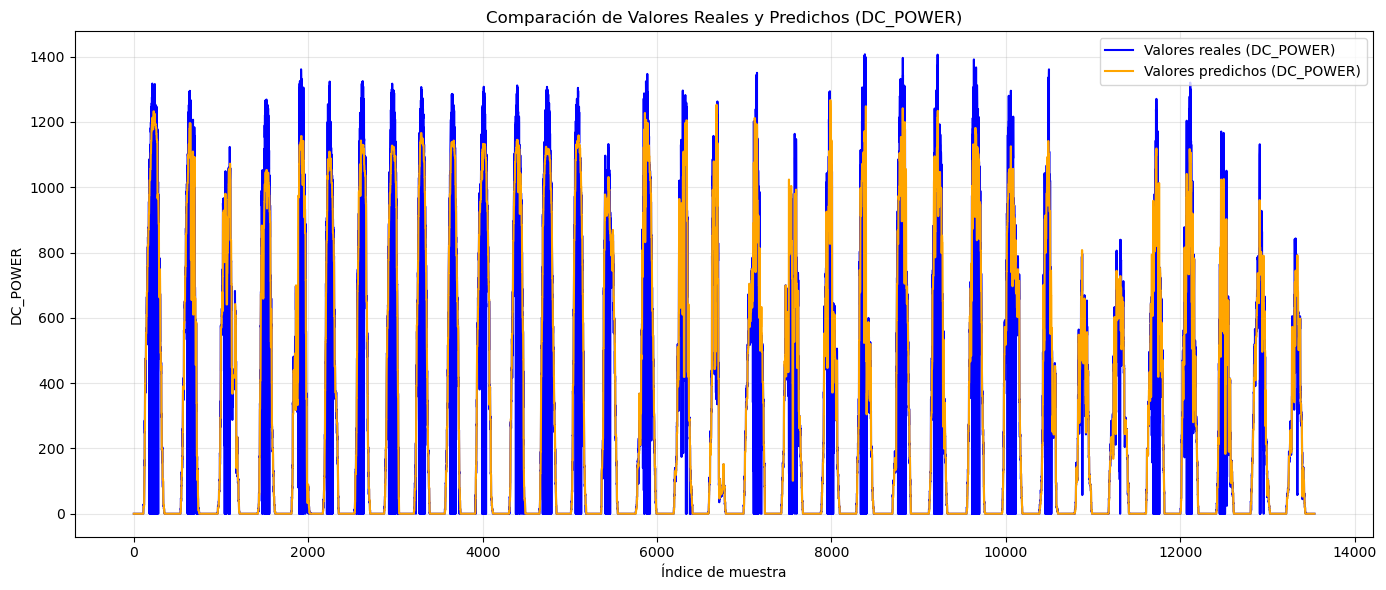

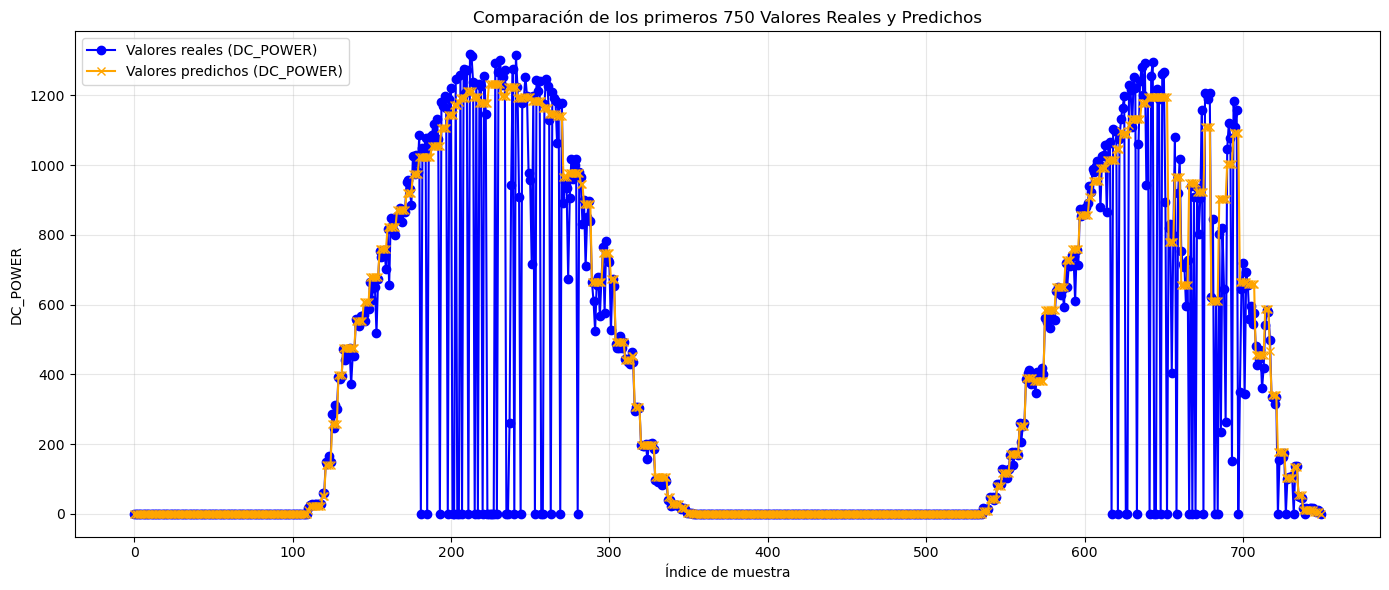

In [4]:
import matplotlib.pyplot as plt


# Supongamos que `Y_test` son los valores reales y `Y_pred` son los valores predichos
def plot_real_vs_predicted(Y_test, Y_pred, num_samples=750):
    """
    Genera gráficas comparativas entre los valores reales y predichos.
    
    Args:
        Y_test: Valores reales.
        Y_pred: Valores predichos por el modelo.
        num_samples: Número de muestras para mostrar (por defecto 100).
    """
    # Crear una gráfica general
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test, label='Valores reales (DC_POWER)', color='blue')
    plt.plot(Y_pred, label='Valores predichos (DC_POWER)', color='orange')
    plt.title('Comparación de Valores Reales y Predichos (DC_POWER)')
    plt.xlabel('Índice de muestra')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Crear una gráfica con una sección ampliada
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test[:num_samples], label='Valores reales (DC_POWER)', color='blue', marker='o')
    plt.plot(Y_pred[:num_samples], label='Valores predichos (DC_POWER)', color='orange', marker='x')
    plt.title(f'Comparación de los primeros {num_samples} Valores Reales y Predichos')
    plt.xlabel('Índice de muestra')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Llamar a la función con los valores reales y predichos
plot_real_vs_predicted(Y_test, Y_pred)


In [7]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import tensorflow as tf

# Función de pérdida ponderada
def weighted_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, tf.shape(y_pred))  # Asegurar dimensiones compatibles
    weights = tf.where(y_true > 800, 3.0, 1.0)  # Aumentar peso para valores altos
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# Transformar DATE_TIME en características útiles
df_GD2_limpio['HOUR'] = pd.to_datetime(df_GD2_limpio['DATE_TIME']).dt.hour

# Codificación trigonométrica para la hora del día
df_GD2_limpio['HOUR_SIN'] = np.sin(2 * np.pi * df_GD2_limpio['HOUR'] / 24)
df_GD2_limpio['HOUR_COS'] = np.cos(2 * np.pi * df_GD2_limpio['HOUR'] / 24)

# Definir las características (X) y la variable objetivo (Y)
features = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR_SIN', 'HOUR_COS']
X = df_GD2_limpio[features].values
Y = df_GD2_limpio['DC_POWER'].values

# Configuración para validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Métricas a recopilar
mse_scores, mae_scores, r2_scores = [], [], []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}")
    
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Escalar las variables predictoras
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train = scaler_x.fit_transform(X_train)
    X_test = scaler_x.transform(X_test)

    # Escalar la variable objetivo
    Y_train = scaler_y.fit_transform(Y_train.reshape(-1, 1))
    Y_test = scaler_y.transform(Y_test.reshape(-1, 1))
    
    # Construcción del modelo
    model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0)),
        #Dropout(0.1),
        Dense(256, activation='relu', kernel_regularizer=l2(0)),
        #Dropout(0.1),
        Dense(128, activation='relu', kernel_regularizer=l2(0)),
        Dense(1)  # Capa de salida
    ])
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss=weighted_loss, metrics=['mae'])
    
    # Configurar early stopping para evitar sobreajuste
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Entrenar el modelo
    history = model.fit(
        X_train, Y_train,
        epochs=300,  # Más épocas para mayor capacidad de aprendizaje
        batch_size=32,
        validation_data=(X_test, Y_test),
        verbose=0,
        callbacks=[early_stop]
    )
    
    # Evaluar el modelo
    mse, mae = model.evaluate(X_test, Y_test, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    # Predicciones y transformación inversa para los valores originales
    Y_pred = model.predict(X_test, verbose=0)
    Y_pred_original = scaler_y.inverse_transform(Y_pred)
    Y_test_original = scaler_y.inverse_transform(Y_test)
    
    # Cálculo de R² con los valores originales
    r2 = r2_score(Y_test_original, Y_pred_original)
    r2_scores.append(r2)

# Resultados finales
print("Resultados de validación cruzada:")
print("MSE en cada fold:", mse_scores)
print("MSE promedio:", np.mean(mse_scores))
print("MAE en cada fold:", mae_scores)
print("MAE promedio:", np.mean(mae_scores))
print("R² en cada fold:", r2_scores)
print("R² promedio:", np.mean(r2_scores))


Fold 1


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Resultados de validación cruzada:
MSE en cada fold: [0.02180340327322483, 0.022188233211636543, 0.02323317714035511, 0.022824585437774658, 0.021376481279730797]
MSE promedio: 0.02228517606854439
MAE en cada fold: [0.06328687071800232, 0.06389768421649933, 0.06837449967861176, 0.06652478873729706, 0.06295905262231827]
MAE promedio: 0.06500857919454575
R² en cada fold: [0.6774793338496863, 0.6697279824110092, 0.6582854326301657, 0.66934676172296, 0.6872865207441387]
R² promedio: 0.672425206271592


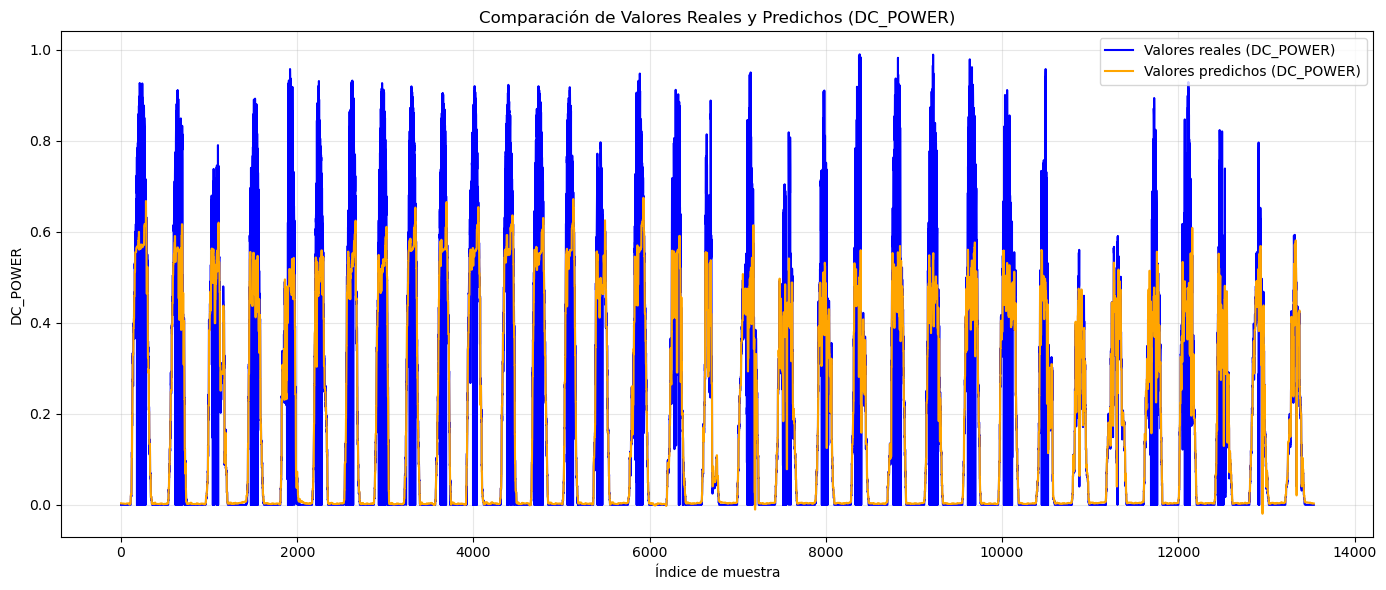

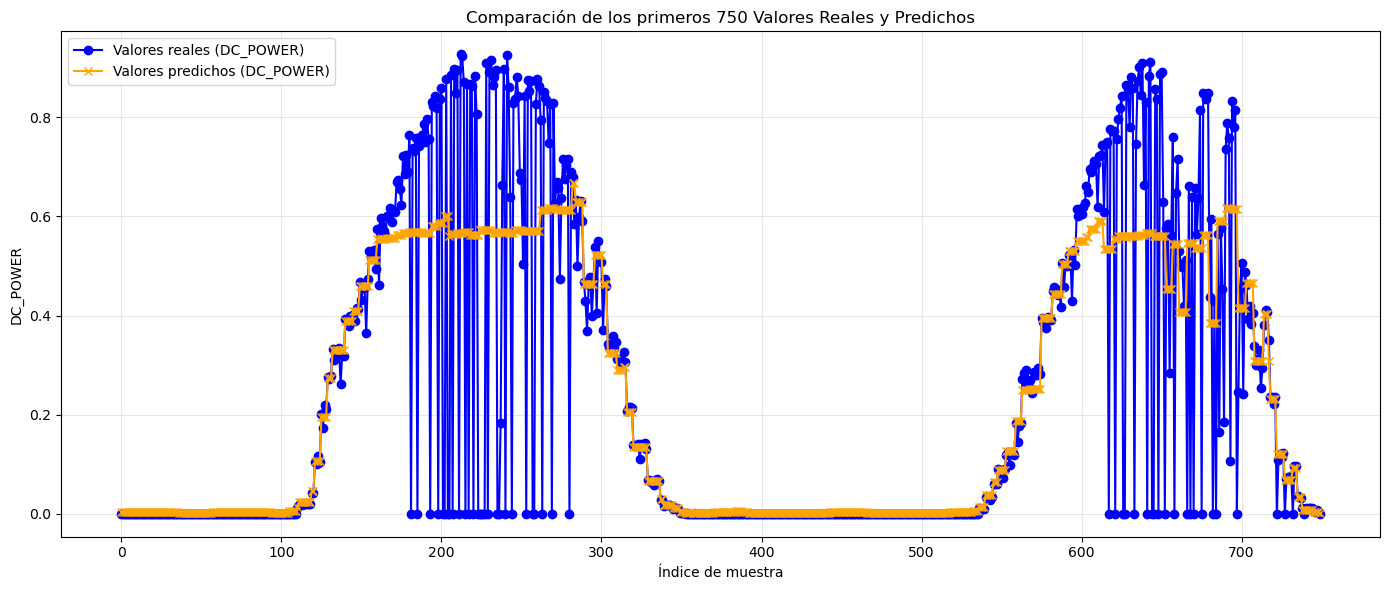

In [8]:
import matplotlib.pyplot as plt


# Supongamos que `Y_test` son los valores reales y `Y_pred` son los valores predichos
def plot_real_vs_predicted(Y_test, Y_pred, num_samples=750):
    """
    Genera gráficas comparativas entre los valores reales y predichos.
    
    Args:
        Y_test: Valores reales.
        Y_pred: Valores predichos por el modelo.
        num_samples: Número de muestras para mostrar (por defecto 100).
    """
    # Crear una gráfica general
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test, label='Valores reales (DC_POWER)', color='blue')
    plt.plot(Y_pred, label='Valores predichos (DC_POWER)', color='orange')
    plt.title('Comparación de Valores Reales y Predichos (DC_POWER)')
    plt.xlabel('Índice de muestra')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Crear una gráfica con una sección ampliada
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test[:num_samples], label='Valores reales (DC_POWER)', color='blue', marker='o')
    plt.plot(Y_pred[:num_samples], label='Valores predichos (DC_POWER)', color='orange', marker='x')
    plt.title(f'Comparación de los primeros {num_samples} Valores Reales y Predichos')
    plt.xlabel('Índice de muestra')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Llamar a la función con los valores reales y predichos
plot_real_vs_predicted(Y_test, Y_pred)
